In [ ]:
import pandas as pd
import string # pré-processamento
import spacy
import random 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from spacy.lang.pt.stop_words import STOP_WORDS

O spacy na classificação de sentimentos trabalha com redes neurais convolucionais. Na aula ```spacy.__version__ = '2.2.3'```. Iremos classificar em **alegria** e **medo**


In [ ]:
modelo_pt_br = 'pt_core_news_sm'

In [ ]:
# Carregamento da base de dados "base_treinamento.txt" e "base_teste.txt"
db = pd.read_csv('base_treinamento.txt', encoding='utf-8')
db

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria
...,...,...
191,estou chocado e amedrontado com este assassina...,medo
192,é preciso afugenta com ímpeto este medo do inf...,medo
193,políticos usam suas forças para afugentar e am...,medo
194,o objetivo disso e apenas me amedrontar mais,medo


(array(['alegria', 'medo'], dtype=object), array([112,  84]))

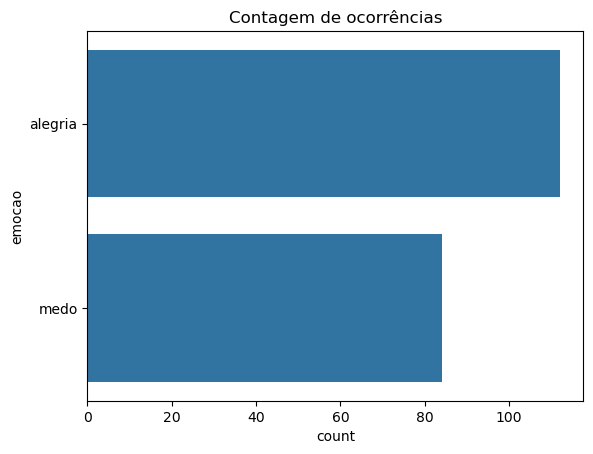

In [ ]:
plt.title("Contagem de ocorrências")
sns.countplot(db['emocao']);
np.unique(db['emocao'], return_counts=True)


### Pré-processamento  
- ```string.punctuation```  
- ```STOP_WORDS```

In [ ]:
PLN = spacy.load(modelo_pt_br)
PLN

In [ ]:
def pre_processamento(texto: str) -> list:
    """
    Percorrer os valores de uma str e adiciona o lema destes na lista
    """ 
    texto = texto.lower()
    documento = PLN(text=texto)

    lista = []
    # Tokenizacao
    for token in documento:
        lista.append(token.lemma_)
    
    # Remocao de Stop word
    lista = [palavra for palavra in lista if palavra not in STOP_WORDS and palavra not in string.punctuation]
    
    # Formato de texto -- # '59'.isdigit() > True
    lista = ' '.join( str(elemento) for elemento in lista if not elemento.isdigit() )
    
    return lista

In [ ]:
teste: str  = 'Estou aprendendo processamento 2 10 23 de linguagem natural, Curso em Curitiba'

In [ ]:
pre_processamento(teste)

'aprender processamento linguagem natural curso curitber'

In [ ]:
db['texto'] = db['texto'].apply(pre_processamento)

In [ ]:
db

,texto,emocao
0,trabalho agradável,alegria
1,gostar ficar em o aconchego,alegria
2,fiz adesão a o curso hoje,alegria
3,admirar,alegria
4,adorar,alegria
...,...,...
191,chocado amedrontar assassinato brutal,medo
192,preciso afugentar ímpeto medo de o inferno,medo
193,político força afugentar amedrontar,medo
194,objetivo de isso amedrontar,medo


## Tratamento da Classe

In [ ]:
db_final =  []

for texto, emocao in zip(db['texto'], db['emocao']):

    if emocao == 'alegria':
        dic = ({'ALEGRIA': True, 'MEDO': False})
    else:
        dic = ({'ALEGRIA': False, 'MEDO': True})

    db_final.append([texto, dic.copy()])
db_final[:10]


[['trabalho agradável', {'ALEGRIA': True, 'MEDO': False}],
 ['gostar ficar em o aconchego', {'ALEGRIA': True, 'MEDO': False}],
 ['fiz adesão a o curso hoje', {'ALEGRIA': True, 'MEDO': False}],
 ['admirar', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar cabelo macio', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar cor de o olho', {'ALEGRIA': True, 'MEDO': False}],
 ['somo amável outro', {'ALEGRIA': True, 'MEDO': False}],
 ['sinto afeição', {'ALEGRIA': True, 'MEDO': False}],
 ['querer agradar filho', {'ALEGRIA': True, 'MEDO': False}]]

## Criação do Classificador - Rede Neural

In [ ]:
modelo_pt_br

'pt_core_news_sm'

In [ ]:
# NN
modelo = spacy.blank('pt') #  ... = 'pt' 

# Labels 
categorias = modelo.add_pipe('textcat') # text category
categorias.add_label("ALEGRIA")
categorias.add_label("MEDO")

# modelo.add_pipe(categorias)

# Armazenar os resultados
historico = []

In [ ]:
from spacy.training import Example

# Iniciar o treinamento
modelo.begin_training()

for epoca in range(1_000):
    random.shuffle(db_final)  # Embaralha os dados de treinamento

    # Controlar o erro
    losses = {}

    # Processar os lotes
    for batch in spacy.util.minibatch(db_final, size=30):
        textos = [modelo.make_doc(texto) for texto, _ in batch]
        annotations = [{"cats": entities} for _, entities in batch]
        
        # Criar os exemplos no formato novo
        exemplos = [Example.from_dict(doc, annotation) for doc, annotation in zip(textos, annotations)]
        
        # Atualizar o modelo com os exemplos
        modelo.update(examples=exemplos, losses=losses)

    # Monitorar o progresso a cada 100 épocas
    if epoca % 100 == 0:
        print(f"Losses: {losses}")
        historico.append(losses)


Losses: {'textcat': 1.7143274992704391}
Losses: {'textcat': 4.462947459510369e-11}
Losses: {'textcat': 5.607058437342993e-12}
Losses: {'textcat': 1.3724281517561547e-12}
Losses: {'textcat': 4.2801549420868907e-13}
Losses: {'textcat': 1.9559594185470947e-13}
Losses: {'textcat': 7.7527803343531e-14}
Losses: {'textcat': 3.963494440318443e-14}
Losses: {'textcat': 1.7433623014783827e-14}
Losses: {'textcat': 1.0797976858630768e-14}


In [ ]:
erros = [ historico[i].get('textcat') for i in range(len(historico))]

In [ ]:
[i*100 for i in range(1,11)]

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

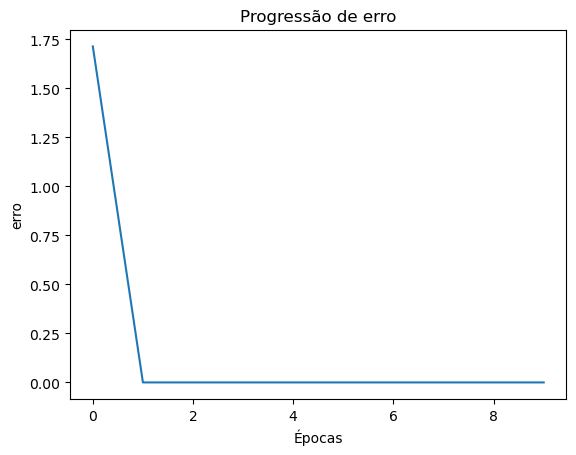

In [ ]:
plt.title("Progressão de erro");
plt.xlabel("Épocas");
plt.ylabel("erro");
plt.plot(erros);

In [ ]:
# Cria uma pasta do modelo criado nesse notebook
modelo.to_disk("trained_model")